# Загрузка данных

Импорт и установка библиотек

In [1]:
# Установка необходимых библиотек
!pip install spacy nltk scikit-learn transformers datasets iterative-stratification wordcloud evaluate
!python -m spacy download ru_core_news_md

# Импорт стандартных библиотек
import re
import os
import json
import warnings
from copy import deepcopy
from IPython.display import display
from PIL import Image

# Импорт научных и визуализационных библиотек
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Импорт ML и NLP библиотек
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import (
    classification_report, accuracy_score, f1_score,
    roc_auc_score, roc_curve, precision_score, recall_score
)
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from nltk import download as nltk_download

# Импорт transformers и связанных библиотек
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import (
    AutoTokenizer, AutoConfig, AutoModelForSequenceClassification,
    Trainer, TrainingArguments, EarlyStoppingCallback
)
from sentence_transformers import SentenceTransformer
from datasets import Dataset
import evaluate

# Настройки
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# Установка seed для воспроизводимости
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# Дополнительные загрузки для NLP
try:
    nltk_download('punkt')
except:
    pass

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 MB 16.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('ru_core_news_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Анализ и предобработка

### просмотр статистической информации

In [2]:
# # === ШАГ 1: Объединяем два исходных файла ===
# df1 = pd.read_csv("/content/project-13-at-2025-05-11-01-19-e254a3e5.csv")
# df2 = pd.read_csv("/content/project-20-at-2025-05-15-05-35-2831ec76.csv")
# df = pd.concat([df1, df2], ignore_index=True)
df = pd.read_csv("/content/321.csv")
# === ШАГ 2: Разметка sentiment ===
known_categories = [
    "Вопрос решен",
    "Нравится качество выполнения заявки",
    "Нравится качество работы сотрудников",
    "Нравится скорость отработки заявок",
    "Понравилось выполнение заявки"
]

# Добавляем колонки (в том числе "Другое")
for col in known_categories + ["Другое"]:
    if col not in df.columns:
        df[col] = 0

df["sentiment"] = df["sentiment"].fillna("")

for i, row in df.iterrows():
    try:
        sentiment_data = json.loads(row["sentiment"])
        choices = sentiment_data.get("choices", [])

        for col in known_categories + ["Другое"]:
            df.at[i, col] = 0  # обнуляем

        for choice in choices:
            if choice in known_categories:
                df.at[i, choice] = 1
            else:
                df.at[i, "Другое"] = 1
    except Exception:
        for col in known_categories + ["Другое"]:
            df.at[i, col] = 0

# Сохраняем объединённый с разметкой файл
df.to_csv("/content/merged_with_sentiment_flags.csv", index=False)

# === ШАГ 3: Сравнение по ID с разметкой ===
df_base = pd.read_csv("/content/разметка комментариев 2.csv")
df_other = pd.read_csv("/content/merged_with_sentiment_flags.csv")

if 'id' in df_base.columns and 'id' in df_other.columns:
    df_matched = df_other[df_other['id'].isin(df_base['id'])]

    # Сбрасываем индекс, чтобы он начинался с 1 (а не с 0)
    df_matched = df_matched.reset_index(drop=True)
    df_matched.index = df_matched.index + 1  # Делаем индексацию с 1

    df_matched.to_csv("/content/коментарии.csv", index=True)  # index=True сохраняет новый индекс
    print("Файл коментарии.csv сохранён успешно.")
else:
    print("В одном из файлов отсутствует колонка 'id'.")

Файл коментарии.csv сохранён успешно.


In [3]:
print("\n=== Информация о DataFrame (с дубликатами) ===")
print(f"Общее количество строк: {len(df_matched)}")
print(f"Количество уникальных строк: {len(df_matched.drop_duplicates())}")
print(f"Количество полных дубликатов: {len(df_matched) - len(df_matched.drop_duplicates())}")


=== Информация о DataFrame (с дубликатами) ===
Общее количество строк: 2368
Количество уникальных строк: 2368
Количество полных дубликатов: 0


In [4]:
print("\n \n ===Типы данных и пропуски: ===")
print(df_matched.info())


 
 ===Типы данных и пропуски: ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2368 entries, 1 to 2368
Data columns (total 15 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   annotation_id                         2368 non-null   int64  
 1   annotator                             2368 non-null   int64  
 2   comment                               2368 non-null   object 
 3   created_at                            2368 non-null   object 
 4   id                                    2368 non-null   int64  
 5   lead_time                             2368 non-null   float64
 6   rating                                2368 non-null   int64  
 7   sentiment                             2362 non-null   object 
 8   updated_at                            2368 non-null   object 
 9   Вопрос решен                          2368 non-null   float64
 10  Нравится качество выполнения заявки   2368 non-nu

In [5]:
df_matched.head(10)

,annotation_id,annotator,comment,created_at,id,lead_time,rating,sentiment,updated_at,Вопрос решен,Нравится качество выполнения заявки,Нравится качество работы сотрудников,Нравится скорость отработки заявок,Понравилось выполнение заявки,Другое
1,16,2,спасибо,2025-05-08T12:32:06.806278Z,2945792,49.604,5,Вопрос решен,2025-05-08T12:44:22.535929Z,0.0,0.0,0.0,0.0,0.0,0
2,17,2,спасибо!,2025-05-08T12:44:25.556719Z,3234340,2.058,5,Вопрос решен,2025-05-08T12:44:25.556719Z,0.0,0.0,0.0,0.0,0.0,0
3,18,2,Отлично,2025-05-08T12:44:46.429049Z,3380332,19.677,5,"{""choices"":[""Понравилось выполнение заявки"",""В...",2025-05-08T12:44:46.429049Z,1.0,0.0,0.0,0.0,1.0,0
4,19,2,Благодарю за оперативное решение проблемы !,2025-05-08T12:45:09.100228Z,3381812,21.395,5,"{""choices"":[""Нравится скорость отработки заяво...",2025-05-08T12:45:09.100228Z,1.0,0.0,0.0,1.0,0.0,0
5,20,2,Прекрасный специалист! Побольше таких,2025-05-08T12:45:23.515860Z,3461991,13.272,5,Нравится качество работы сотрудников,2025-05-08T12:45:23.515860Z,0.0,0.0,0.0,0.0,0.0,0
6,21,2,Спасибо,2025-05-08T12:45:27.145914Z,3551430,2.614,5,Вопрос решен,2025-05-08T12:45:27.145914Z,0.0,0.0,0.0,0.0,0.0,0
7,22,2,"пересчет, и скорость \r\n",2025-05-08T12:45:45.852182Z,3572768,52.652,1,ни к одному из перечисленных,2025-05-08T17:38:36.616640Z,0.0,0.0,0.0,0.0,0.0,0
8,23,2,Спасибо за обновление покраски стен,2025-05-08T12:46:20.388583Z,3584536,23.622,5,"{""choices"":[""Понравилось выполнение заявки"",""В...",2025-05-08T12:46:20.388583Z,1.0,0.0,0.0,0.0,1.0,0
9,24,2,выполнили быстро,2025-05-08T12:46:48.890441Z,3596020,27.413,5,"{""choices"":[""Нравится скорость отработки заяво...",2025-05-08T12:46:48.890441Z,1.0,0.0,0.0,1.0,0.0,0
10,25,2,Спасибо!,2025-05-08T12:46:52.648930Z,3617808,2.575,5,Вопрос решен,2025-05-08T12:46:52.648930Z,0.0,0.0,0.0,0.0,0.0,0


In [6]:
df_matched.tail(10)

,annotation_id,annotator,comment,created_at,id,lead_time,rating,sentiment,updated_at,Вопрос решен,Нравится качество выполнения заявки,Нравится качество работы сотрудников,Нравится скорость отработки заявок,Понравилось выполнение заявки,Другое
2359,2374,2,спасибо большое за оперативность!!!,2025-05-10T20:12:01.773693Z,3807877,4.562,5,"{""choices"":[""Нравится скорость отработки заяво...",2025-05-10T20:12:01.773693Z,1.0,0.0,0.0,1.0,0.0,0
2360,2375,2,"все отлично, проблема решена",2025-05-10T20:12:06.360904Z,3798582,3.760,5,"{""choices"":[""Понравилось выполнение заявки"",""В...",2025-05-10T20:12:06.360904Z,1.0,0.0,0.0,0.0,1.0,0
2361,2376,2,оплачено,2025-05-10T20:12:11.427188Z,3669717,4.122,5,Вопрос решен,2025-05-10T20:12:11.427188Z,0.0,0.0,0.0,0.0,0.0,0
2362,2377,2,лампочки как перегорели так и никто их не поме...,2025-05-10T20:12:20.080912Z,3665945,7.694,5,ни к одному из перечисленных,2025-05-10T20:12:20.080912Z,0.0,0.0,0.0,0.0,0.0,0
2363,2378,2,проблема не устранена! запах от тех. шкафа ост...,2025-05-10T20:12:24.365900Z,3542834,2.833,5,ни к одному из перечисленных,2025-05-10T20:12:24.365900Z,0.0,0.0,0.0,0.0,0.0,0
2364,2379,2,"долго, но приятно",2025-05-10T20:12:27.250167Z,3507812,2.124,5,Вопрос решен,2025-05-10T20:12:27.251168Z,0.0,0.0,0.0,0.0,0.0,0
2365,2380,2,16.03.2024 г ребята установили кондиционер. ра...,2025-05-10T20:12:37.420217Z,3478532,9.359,5,"{""choices"":[""Нравится скорость отработки заяво...",2025-05-10T20:12:37.420217Z,1.0,1.0,1.0,1.0,1.0,1
2366,2381,2,два дня мусоропровод. сегодня с утра тоже,2025-05-10T20:12:47.220202Z,3296403,8.697,5,Вопрос решен,2025-05-10T20:12:47.220202Z,0.0,0.0,0.0,0.0,0.0,0
2367,2382,2,отрегулировать дверь замки . для должного откр...,2025-05-10T20:12:52.522679Z,3165822,4.581,5,ни к одному из перечисленных,2025-05-10T20:12:52.522679Z,0.0,0.0,0.0,0.0,0.0,0
2368,2383,2,всё сделано хорошо,2025-05-10T20:12:55.135450Z,2991660,1.833,5,Вопрос решен,2025-05-10T20:12:55.135450Z,0.0,0.0,0.0,0.0,0.0,0


In [7]:
df_matched = df_matched.dropna()

In [8]:
df_matched.describe()

,annotation_id,annotator,id,lead_time,rating,Вопрос решен,Нравится качество выполнения заявки,Нравится качество работы сотрудников,Нравится скорость отработки заявок,Понравилось выполнение заявки,Другое
count,2362.000000,2362.0,2.362000e+03,2362.000000,2362.000000,2362.000000,2362.000000,2362.000000,2362.000000,2362.000000,2362.000000
mean,1200.052075,2.0,4.045879e+06,6.853704,4.954699,0.569856,0.065622,0.167655,0.353514,0.184589,0.024979
std,683.806424,0.0,1.654149e+05,10.838498,0.382901,0.495201,0.247673,0.373638,0.478162,0.388046,0.156094
min,16.000000,2.0,2.945792e+06,0.724000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,608.250000,2.0,3.912308e+06,2.003000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1201.500000,2.0,3.952989e+06,3.918500,5.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1791.750000,2.0,4.203971e+06,7.951750,5.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,2383.000000,2.0,4.237692e+06,213.268000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [9]:
df_matched.shape

(2362, 15)

In [10]:
#Удаление колонок не нужных для обучения модели и не применяющиеся в анализе
df_clean =df_matched.drop(columns=['annotation_id', 'annotator', 'id','updated_at', 'lead_time','sentiment', 'created_at'])

In [11]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2362 entries, 1 to 2368
Data columns (total 8 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   comment                               2362 non-null   object 
 1   rating                                2362 non-null   int64  
 2   Вопрос решен                          2362 non-null   float64
 3   Нравится качество выполнения заявки   2362 non-null   float64
 4   Нравится качество работы сотрудников  2362 non-null   float64
 5   Нравится скорость отработки заявок    2362 non-null   float64
 6   Понравилось выполнение заявки         2362 non-null   float64
 7   Другое                                2362 non-null   int64  
dtypes: float64(5), int64(2), object(1)
memory usage: 166.1+ KB


In [12]:
df_clean.head(15)

,comment,rating,Вопрос решен,Нравится качество выполнения заявки,Нравится качество работы сотрудников,Нравится скорость отработки заявок,Понравилось выполнение заявки,Другое
1,спасибо,5,0.0,0.0,0.0,0.0,0.0,0
2,спасибо!,5,0.0,0.0,0.0,0.0,0.0,0
3,Отлично,5,1.0,0.0,0.0,0.0,1.0,0
4,Благодарю за оперативное решение проблемы !,5,1.0,0.0,0.0,1.0,0.0,0
5,Прекрасный специалист! Побольше таких,5,0.0,0.0,0.0,0.0,0.0,0
6,Спасибо,5,0.0,0.0,0.0,0.0,0.0,0
7,"пересчет, и скорость \r\n",1,0.0,0.0,0.0,0.0,0.0,0
8,Спасибо за обновление покраски стен,5,1.0,0.0,0.0,0.0,1.0,0
9,выполнили быстро,5,1.0,0.0,0.0,1.0,0.0,0
10,Спасибо!,5,0.0,0.0,0.0,0.0,0.0,0


### Визуализация

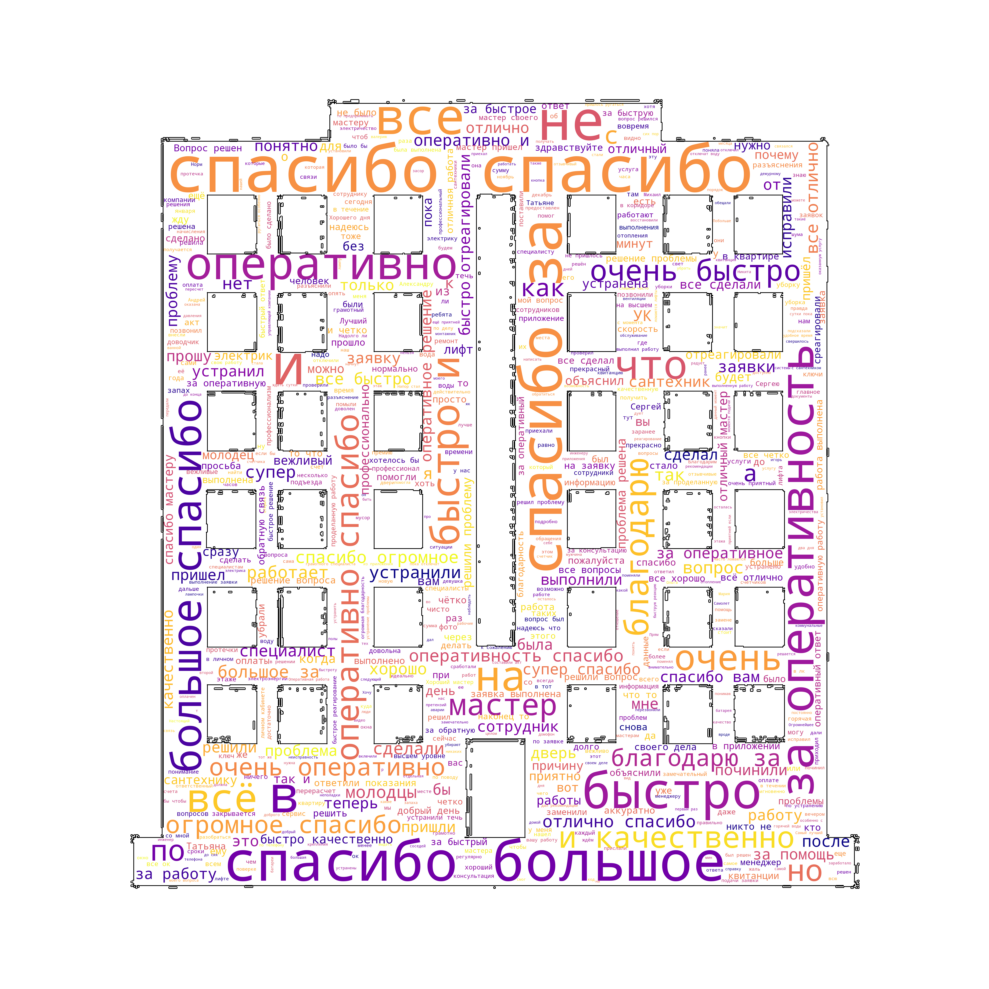

In [13]:
# Маска из изображения здания
mask = np.array(Image.open("/content/building (1).png"))

# Объединяем все комментарии в одну строку
text_all = " ".join(df_clean['comment'].dropna())

# Создание облака слов без стоп-слов
wordcloud = WordCloud(
    width=2000,
    height=1800,
    background_color='white',
    mask=mask,
    contour_color='black',
    contour_width=3,
    max_words=1500,
    colormap='plasma',
    prefer_horizontal=0.95,
    max_font_size=200,
    scale=5,  # увеличивает детализацию!
    random_state=42
).generate(text_all)

# Отображение
plt.figure(figsize=(12, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout()
plt.show()




На этом графике можно уведить что больше всего люди пишут отзывы используя такие слова как спасибо,быстро,оперативно и т.д

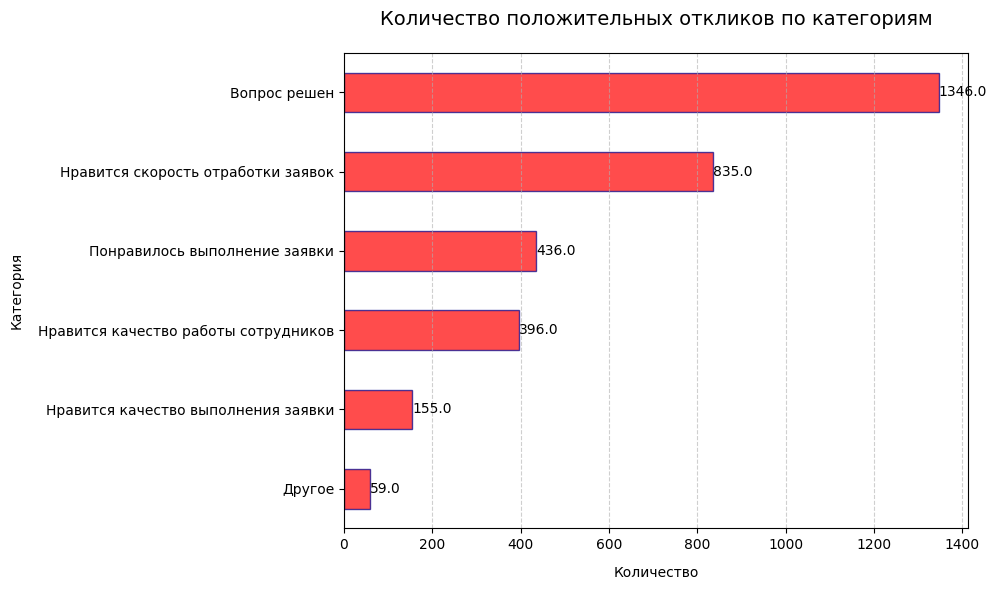

In [14]:
# Явно указываем столбцы для исключения
exclude_cols = ['comment', 'rating']
category_cols = [col for col in df_clean.columns if col not in exclude_cols]

# Строим график
plt.figure(figsize=(10, 6))
df_clean[category_cols].sum().sort_values().plot(
    kind='barh',
    color='red',
    edgecolor='darkblue',  # Добавляем границы для лучшей читаемости
    alpha=0.7  # Полупрозрачность
)

# Улучшаем оформление
plt.title("Количество положительных откликов по категориям", pad=20, fontsize=14)
plt.xlabel("Количество", labelpad=10)
plt.ylabel("Категория", labelpad=10)
plt.grid(True, axis='x', linestyle='--', alpha=0.6)

# Добавляем значения на столбцы
for i, v in enumerate(df_clean[category_cols].sum().sort_values()):
    plt.text(v + 0.5, i, str(v), color='black', va='center')

plt.tight_layout()
plt.show()

На этом графике можно заменить очень сильный дисбаланс классов

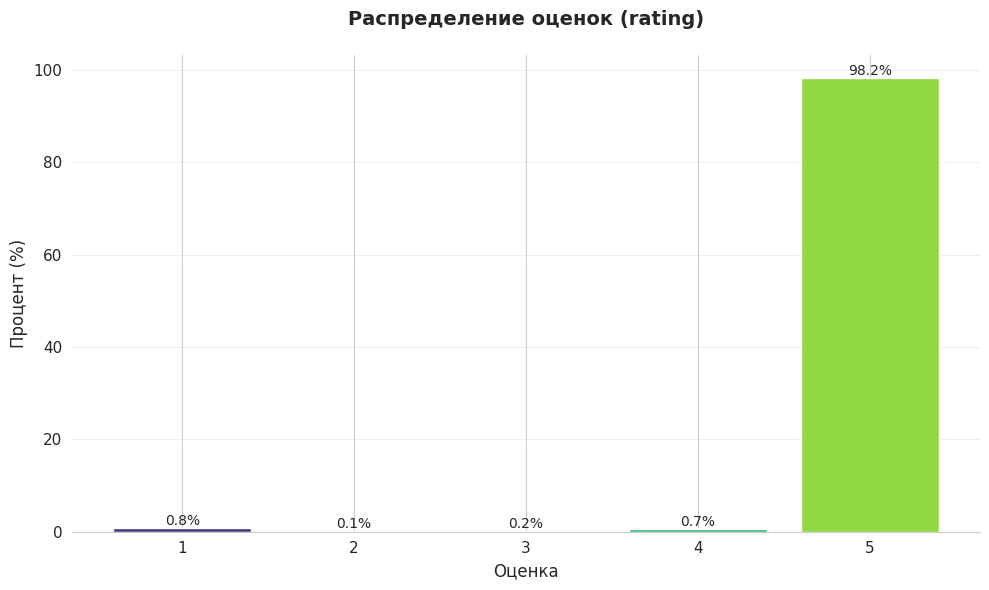

In [15]:
# Подсчёт и нормализация
rating_percent = df_clean['rating'].value_counts(normalize=True).sort_index() * 100

# Настройка стиля
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# Создаем цветовую палитру
colors = sns.color_palette("viridis", len(rating_percent))

# Построение графика
bars = plt.bar(rating_percent.index.astype(str), rating_percent.values, color=colors)

# Добавляем данные на каждый столбец
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1f}%',
             ha='center', va='bottom',
             fontsize=10)

# Настройка оформления
plt.title("Распределение оценок (rating)\n", fontsize=14, fontweight='bold')
plt.ylabel("Процент (%)", fontsize=12)
plt.xlabel("Оценка", fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

# Убираем лишние границы
sns.despine(left=True)

# Добавляем горизонтальную сетку
plt.grid(axis='y', alpha=0.3)

# Оптимизация расположения элементов
plt.tight_layout()

plt.show()

На этом графике видно распредление оценок в процентном соотношении и наблюдаеться что больше всего данных это 5 звезд

## Работа с текстом

In [16]:
# Названия и параметры моделей
MODEL_NAMES = ["cointegrated/rubert-tiny2", "DeepPavlov/rubert-base-cased"]
SBERT_MODEL_NAME = MODEL_NAMES[0]  # используем первую модель для лог. регрессии

USE_LR = True                   # Флаг: использовать ли лог. регрессию
MAX_LENGTH = 256
NUM_LABELS = 6
SEED = 42
TRAIN_BATCH_SIZE = 32
EVAL_BATCH_SIZE = 32
LEARNING_RATE = 3e-5
WEIGHT_DECAY = 0.01
NUM_EPOCHS = 10
WARMUP_RATIO = 0.2
LOGGING_STEPS = 50
SAVE_TOTAL_LIMIT = 2
OUTPUT_DIR = "./results"
LOGGING_DIR = "./logs"
early_stopping = EarlyStoppingCallback(early_stopping_patience=4)

### Очистка текста

In [17]:
import re
import pandas as pd
import torch
from sentence_transformers import SentenceTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import MultiLabelBinarizer
from datasets import Dataset
from transformers import EarlyStoppingCallback

# Очистка текста
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[\r\n]+', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()  # Пунктуация, эмодзи и спецсимволы сохраняются

# Очистка комментариев
df_clean['comment'] = df_clean['comment'].apply(clean_text)

# Категории для классификации
category_cols = [
    'Вопрос решен',
    'Нравится качество выполнения заявки',
    'Нравится качество работы сотрудников',
    'Нравится скорость отработки заявок',
    'Понравилось выполнение заявки',
    'Другое'
]

# Подготовка DataFrame
df_model = df_clean[['comment'] + category_cols].copy()
df_model = df_model.rename(columns={'comment': 'text'})
df_model[category_cols] = df_model[category_cols].astype(int)

# Генерация эмбеддингов SBERT для логистической регрессии
if USE_LR:
    print("Генерируем эмбеддинги SBERT для логистической регрессии...")
    sbert = SentenceTransformer(SBERT_MODEL_NAME)
    X_embeddings = sbert.encode(
        df_model['text'].tolist(),
        batch_size=64,
        show_progress_bar=True
    )
    y_labels = df_model[category_cols].values

# Подсчёт весов классов
all_labels = df_model[category_cols].values
pos_counts = all_labels.sum(axis=0)
neg_counts = all_labels.shape[0] - pos_counts
pos_weight = torch.tensor(neg_counts / pos_counts, dtype=torch.float32)



Генерируем эмбеддинги SBERT для логистической регрессии...


Batches:   0%|          | 0/37 [00:00<?, ?it/s]

In [18]:
# Вывод статистики по классам
print("Распределение классов:")
print(f"Всего комментариев: {all_labels.shape[0]}\n")

for i, col in enumerate(category_cols):
    print(f"Класс '{col}':")
    print(f"  Положительных: {pos_counts[i]} ({pos_counts[i]/all_labels.shape[0]:.1%})")
    print(f"  Отрицательных: {neg_counts[i]} ({neg_counts[i]/all_labels.shape[0]:.1%})")
    print(f"  Вес класса (neg/pos): {pos_weight[i]:.2f}\n")

print("\nИтоговые веса для loss-функции:")
print(pos_weight)

Распределение классов:
Всего комментариев: 2362

Класс 'Вопрос решен':
  Положительных: 1346 (57.0%)
  Отрицательных: 1016 (43.0%)
  Вес класса (neg/pos): 0.75

Класс 'Нравится качество выполнения заявки':
  Положительных: 155 (6.6%)
  Отрицательных: 2207 (93.4%)
  Вес класса (neg/pos): 14.24

Класс 'Нравится качество работы сотрудников':
  Положительных: 396 (16.8%)
  Отрицательных: 1966 (83.2%)
  Вес класса (neg/pos): 4.96

Класс 'Нравится скорость отработки заявок':
  Положительных: 835 (35.4%)
  Отрицательных: 1527 (64.6%)
  Вес класса (neg/pos): 1.83

Класс 'Понравилось выполнение заявки':
  Положительных: 436 (18.5%)
  Отрицательных: 1926 (81.5%)
  Вес класса (neg/pos): 4.42

Класс 'Другое':
  Положительных: 59 (2.5%)
  Отрицательных: 2303 (97.5%)
  Вес класса (neg/pos): 39.03


Итоговые веса для loss-функции:
tensor([ 0.7548, 14.2387,  4.9646,  1.8287,  4.4174, 39.0339])


In [19]:
from datasets import Dataset

# Создаём датасет HuggingFace
dataset = Dataset.from_pandas(df_model)
dataset = dataset.shuffle(seed=SEED)

# Добавляем поле 'labels' как список значений категорий
def format_labels(example):
    example["labels"] = [float(example[col]) for col in category_cols]
    return example

dataset = dataset.map(format_labels)

# Удаляем отдельные метки (оставляем только 'text' и 'labels')
columns_to_remove = [col for col in category_cols if col in dataset.column_names]
dataset = dataset.remove_columns(columns_to_remove)

Map:   0%|          | 0/2362 [00:00<?, ? examples/s]

### Токенизация

In [21]:
### Токенизация — универсальная для всех моделей в MODEL_NAMES
from transformers import AutoTokenizer
from functools import partial

def get_tokenizer(model_name):
    """
    Возвращает токенизатор для указанной модели с правильными настройками.
    """
    # Определяем, нужно ли добавить пробел перед первым словом (для RoBERTa и подобных)
    add_prefix_space = "roberta" in model_name.lower()

    tokenizer = AutoTokenizer.from_pretrained(
        model_name,
        add_prefix_space=add_prefix_space  # Устанавливаем здесь для моделей типа RoBERTa
    )

    # Если у токенизатора нет pad_token - добавляем его
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token if tokenizer.eos_token else tokenizer.cls_token
        if tokenizer.pad_token is None:  # крайний случай
            tokenizer.add_special_tokens({'pad_token': '[PAD]'})

    return tokenizer

def build_tokenize_fn(model_name, max_length=512):
    """
    Возвращает функцию токенизации для конкретной модели.
    """
    tokenizer = get_tokenizer(model_name)

    def tokenize(examples):
        return tokenizer(
            examples["text"],
            padding="max_length",
            truncation=True,
            max_length=max_length
        )

    return tokenize

# Токенизируем данные для всех моделей
tokenized_datasets = {}
for model_name in MODEL_NAMES:
    print(f"Токенизируем для: {model_name}")
    tokenize_fn = build_tokenize_fn(model_name, MAX_LENGTH)
    tokenized_datasets[model_name] = dataset.map(
        tokenize_fn,
        batched=True,
        remove_columns=["text"]
    )


Токенизируем для: cointegrated/rubert-tiny2


Map:   0%|          | 0/2362 [00:00<?, ? examples/s]

Токенизируем для: DeepPavlov/rubert-base-cased


Map:   0%|          | 0/2362 [00:00<?, ? examples/s]

### Подготовка данных для обучения и стратифицированное разбиение

In [22]:
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from datasets import Dataset

# === Инициализация входных данных ===
X_raw = df_model['text'].values
y_raw = df_model[category_cols].values

# === Внешний сплит: train+val и test ===
outer_splitter = MultilabelStratifiedKFold(n_splits=2, shuffle=True, random_state=SEED)
outer_splits = list(outer_splitter.split(X_raw, y_raw))

train_val_idx, test_idx = outer_splits[0]
train_val_df = df_model.iloc[train_val_idx].reset_index(drop=True)
test_df = df_model.iloc[test_idx].reset_index(drop=True)

# === Внутренний сплит: train и val ===
inner_X = train_val_df['text'].values
inner_y = train_val_df[category_cols].values

inner_splitter = MultilabelStratifiedKFold(n_splits=4, shuffle=True, random_state=SEED)
inner_splits = list(inner_splitter.split(inner_X, inner_y))

train_idx, val_idx = inner_splits[0]

# === Финальные DataFrame'ы ===
train_df = train_val_df.iloc[train_idx].reset_index(drop=True)
val_df = train_val_df.iloc[val_idx].reset_index(drop=True)

# === Перевод в HuggingFace Dataset ===
train_dataset_raw = Dataset.from_pandas(train_df)
val_dataset_raw   = Dataset.from_pandas(val_df)
test_dataset_raw  = Dataset.from_pandas(test_df)

# === Добавляем labels ===
def format_labels(example):
    example["labels"] = [float(example[col]) for col in category_cols]
    return example

train_dataset_raw = train_dataset_raw.map(format_labels)
val_dataset_raw   = val_dataset_raw.map(format_labels)
test_dataset_raw  = test_dataset_raw.map(format_labels)

# === Удаляем категориальные метки ===
train_dataset_raw = train_dataset_raw.remove_columns(category_cols)
val_dataset_raw   = val_dataset_raw.remove_columns(category_cols)
test_dataset_raw  = test_dataset_raw.remove_columns(category_cols)

# === Токенизация всех датасетов для каждой модели ===
tokenized_datasets = {}

for model_name in MODEL_NAMES:
    print(f"\nТокенизация для модели: {model_name}")
    tokenizer = get_tokenizer(model_name)

    def tokenize_fn(example):
        return tokenizer(
            example["text"],
            truncation=True,
            padding="max_length",
            max_length=MAX_LENGTH
        )

    tokenized = {
        'train': train_dataset_raw.map(tokenize_fn, batched=True),
        'val':   val_dataset_raw.map(tokenize_fn, batched=True),
        'test':  test_dataset_raw.map(tokenize_fn, batched=True)
    }

    # Удаляем лишние поля
    for split in ['train', 'val', 'test']:
        ds = tokenized[split]
        if "text" in ds.column_names:
            ds = ds.remove_columns(["text"])
        if "index" in ds.column_names:
            ds = ds.remove_columns(["index"])
        if "index_level_0" in ds.column_names:
            ds = ds.remove_columns(["index_level_0"])
        tokenized[split] = ds

    tokenized_datasets[model_name] = tokenized

# === Если используем лог. регрессию — также делим эмбеддинги ===
if USE_LR:
    X_train = X_embeddings[train_val_idx][train_idx]
    X_val   = X_embeddings[train_val_idx][val_idx]
    X_test  = X_embeddings[test_idx]

    y_train = y_labels[train_val_idx][train_idx]
    y_val   = y_labels[train_val_idx][val_idx]
    y_test  = y_labels[test_idx]

# === Контрольный вывод ===
for model_name in MODEL_NAMES:
    print(f"\nМодель: {model_name}")
    print(f"Train: {len(tokenized_datasets[model_name]['train'])}, "
          f"Val: {len(tokenized_datasets[model_name]['val'])}, "
          f"Test: {len(tokenized_datasets[model_name]['test'])}")

print("\nПорядок классов в labels:", category_cols)

Map:   0%|          | 0/886 [00:00<?, ? examples/s]

Map:   0%|          | 0/295 [00:00<?, ? examples/s]

Map:   0%|          | 0/1181 [00:00<?, ? examples/s]


Токенизация для модели: cointegrated/rubert-tiny2


Map:   0%|          | 0/886 [00:00<?, ? examples/s]

Map:   0%|          | 0/295 [00:00<?, ? examples/s]

Map:   0%|          | 0/1181 [00:00<?, ? examples/s]


Токенизация для модели: DeepPavlov/rubert-base-cased


Map:   0%|          | 0/886 [00:00<?, ? examples/s]

Map:   0%|          | 0/295 [00:00<?, ? examples/s]

Map:   0%|          | 0/1181 [00:00<?, ? examples/s]


Модель: cointegrated/rubert-tiny2
Train: 886, Val: 295, Test: 1181

Модель: DeepPavlov/rubert-base-cased
Train: 886, Val: 295, Test: 1181

Порядок классов в labels: ['Вопрос решен', 'Нравится качество выполнения заявки', 'Нравится качество работы сотрудников', 'Нравится скорость отработки заявок', 'Понравилось выполнение заявки', 'Другое']


### Настройка модели и функции потерь

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import Trainer, AutoConfig, AutoModelForSequenceClassification


In [24]:
class WeightedFocalLoss(nn.Module):
    def __init__(self, pos_weight=None, gamma=2.0, reduction='mean'):
        super().__init__()
        self.register_buffer('pos_weight', pos_weight)  # pos_weight как буфер (для Device-совместимости)
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        # Убедимся, что pos_weight на том же устройстве, что и inputs
        pos_weight = self.pos_weight.to(inputs.device) if self.pos_weight is not None else None

        # BCEWithLogitsLoss + Focal модификация
        bce_loss = F.binary_cross_entropy_with_logits(
            inputs,
            targets,
            weight=None,  # pos_weight применяется вручную
            reduction='none'
        )

        # Применяем pos_weight (если задан)
        if pos_weight is not None:
            weighted_targets = targets * (pos_weight - 1) + 1  # w = 1 для neg, w = pos_weight для pos
            bce_loss = bce_loss * weighted_targets

        # Focal Loss компонент
        pt = torch.exp(-bce_loss)
        focal_loss = (1 - pt) ** self.gamma * bce_loss

        # Редукция (mean/sum/none)
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

In [34]:
from transformers import Trainer

class CustomTrainer(Trainer):
    """
    Кастомный Trainer для обработки multi-label классификации
    с поддержкой пользовательских функций потерь (Focal Loss и др.)
    """
    def __init__(self, loss_fn=None, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.loss_fn = loss_fn  # Наша кастомная функция потерь

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        """
        Переопределяем метод расчета потерь

        Args:
            model: модель transformers
            inputs: входные данные (уже на нужном устройстве)
            return_outputs: возвращать ли outputs модели вместе с loss
            **kwargs: дополнительные аргументы для совместимости (включая num_items_in_batch)
        """
        # Извлекаем метки (labels автоматически перемещены на то же устройство, что и модель)
        labels = inputs.pop("labels")

        # Прямой проход модели
        outputs = model(**inputs)
        logits = outputs.logits  # Получаем предсказания модели

        # Вычисляем потери
        if self.loss_fn is not None:
            loss = self.loss_fn(logits, labels)  # Используем кастомную функцию
        else:
            loss = outputs.loss  # Стандартная кросс-энтропия, если не задана своя

        return (loss, outputs) if return_outputs else loss

In [35]:
def get_model(model_name, num_labels, pos_weight=None, use_focal_loss=False):
    config = AutoConfig.from_pretrained(
        model_name,
        num_labels=num_labels,
        problem_type="multi_label_classification",
        # hidden_dropout_prob=0.3,  # Опционально
        # attention_probs_dropout_prob=0.2  # Опционально
    )

    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        config=config,
        # ignore_mismatched_sizes=True  # Если меняется размер выхода
    )

    # Инициализируем loss_fn, если нужно
    loss_fn = None
    if use_focal_loss and pos_weight is not None:
        loss_fn = WeightedFocalLoss(pos_weight=pos_weight, gamma=2.0)

    return model, loss_fn

In [27]:
train_df

,text,Вопрос решен,Нравится качество выполнения заявки,Нравится качество работы сотрудников,Нравится скорость отработки заявок,Понравилось выполнение заявки,Другое
0,спасибо!,0,0,0,0,0,0
1,отлично,1,0,0,0,1,0
2,спасибо управляющей компании за то что прислал...,0,0,1,1,0,0
3,очень радует работа ук. оперативно! спасибо!,1,0,0,1,1,0
4,все исправили,0,0,0,0,0,0
...,...,...,...,...,...,...,...
881,спасибо большое,0,0,0,0,0,0
882,"не убирали, перерасчет",0,0,0,0,0,0
883,"плитку уложили, но в дождь всё равно скапливае...",0,0,0,0,0,0
884,резиновые прокладки в окнах заменены частично....,0,0,0,0,0,0


In [28]:
tr = train_df.copy()
tr = tr.drop(['text'], axis=1)
tr.sum()/len(tr)*100

,0
Вопрос решен,56.884876
Нравится качество выполнения заявки,6.433409
Нравится качество работы сотрудников,16.817156
Нравится скорость отработки заявок,35.440181
Понравилось выполнение заявки,18.510158
Другое,2.483070


In [29]:
tr.sum()

,0
Вопрос решен,504
Нравится качество выполнения заявки,57
Нравится качество работы сотрудников,149
Нравится скорость отработки заявок,314
Понравилось выполнение заявки,164
Другое,22


In [30]:
tes = val_df.copy()
tes = tes.drop(['text'], axis=1)
tes.sum()/len(tes)*100

,0
Вопрос решен,56.610169
Нравится качество выполнения заявки,6.779661
Нравится качество работы сотрудников,16.610169
Нравится скорость отработки заявок,35.254237
Понравилось выполнение заявки,18.305085
Другое,2.372881


In [31]:
tes.sum()

,0
Вопрос решен,167
Нравится качество выполнения заявки,20
Нравится качество работы сотрудников,49
Нравится скорость отработки заявок,104
Понравилось выполнение заявки,54
Другое,7


### Обучение модели и кросс-валидация

In [37]:
# ===========================================
# ОБУЧЕНИЕ МОДЕЛЕЙ + K-Fold КРОСС-ВАЛИДАЦИЯ
# ===========================================
import os
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

from copy import deepcopy
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score,
    precision_score, recall_score
)
from transformers import (
    AutoTokenizer, TrainingArguments
)
from datasets import Dataset
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

# ---------- Общие настройки ----------
os.environ["WANDB_DISABLED"] = "true"

NUM_LABELS       = len(category_cols)
USE_FOCAL_LOSS   = True
N_SPLITS         = 2                     # для внутреннего K-Fold
DEVICE_FP16      = torch.cuda.is_available()  # использовать fp16, если есть CUDA

# ---------- Функция метрик ----------
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    probs = torch.sigmoid(torch.tensor(logits)).numpy()
    preds = (probs >= 0.5).astype(int)

    try:
        roc_auc = roc_auc_score(labels, probs, average="macro")
    except ValueError:
        roc_auc = float("nan")

    return {
        "accuracy":      accuracy_score(labels, preds),
        "f1_macro":      f1_score(labels, preds, average="macro", zero_division=0),
        "precision":     precision_score(labels, preds, average="macro", zero_division=0),
        "recall":        recall_score(labels, preds, average="macro", zero_division=0),
        "roc_auc_macro": roc_auc,
    }

# ---------- Стратифицированные индексы для K-Fold ----------
mskf = MultilabelStratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)
splits = list(mskf.split(df_model["text"].values, df_model[category_cols].values))

# ---------- Хранилище результатов ----------
all_models_metrics = {}

# ---------- Цикл по моделям ----------
for model_name in MODEL_NAMES:
    print(f"\n====================  {model_name}  ====================")

    # --- токенизатор и модель ---
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model, loss_fn = get_model(model_name, NUM_LABELS, pos_weight, USE_FOCAL_LOSS)

    fold_metrics = []

    # --- цикл по фолдам ---
    for fold, (train_idx, val_idx) in enumerate(splits):
        print(f"\n------ Fold {fold + 1}/{N_SPLITS} ------")

        # ----- подготовка данных -----
        train_df = df_model.iloc[train_idx].reset_index(drop=True)
        val_df   = df_model.iloc[val_idx].reset_index(drop=True)

        def add_labels(example):
            example["labels"] = [float(example[col]) for col in category_cols]
            return example

        raw_train_ds = Dataset.from_pandas(train_df).map(add_labels)
        raw_val_ds   = Dataset.from_pandas(val_df).map(add_labels)

        # удаляем текстовые метки-категории
        raw_train_ds = raw_train_ds.remove_columns(category_cols)
        raw_val_ds   = raw_val_ds.remove_columns(category_cols)

        # токенизация
        def tok(ex):
            return tokenizer(
                ex["text"],
                padding="max_length",
                truncation=True,
                max_length=MAX_LENGTH
            )

        train_ds = raw_train_ds.map(tok, batched=True).remove_columns(["text"])
        val_ds   = raw_val_ds.map(tok, batched=True).remove_columns(["text"])

        # ----- TrainingArguments (уникальные для фолда) -----
        training_args = TrainingArguments(
            output_dir   = f"{OUTPUT_DIR}/{model_name.replace('/', '_')}/fold{fold}",
            logging_dir  = f"{LOGGING_DIR}/{model_name.replace('/', '_')}/fold{fold}",
            eval_strategy = "epoch",
            save_strategy       = "epoch",
            load_best_model_at_end = True,
            metric_for_best_model  = "roc_auc_macro",
            greater_is_better      = True,
            num_train_epochs            = NUM_EPOCHS,
            per_device_train_batch_size = TRAIN_BATCH_SIZE,
            per_device_eval_batch_size  = EVAL_BATCH_SIZE,
            learning_rate  = LEARNING_RATE,
            weight_decay   = WEIGHT_DECAY,
            warmup_ratio   = WARMUP_RATIO,
            logging_steps  = LOGGING_STEPS,
            seed           = SEED,
            fp16           = DEVICE_FP16,
            save_total_limit = SAVE_TOTAL_LIMIT,
        )

        # ----- Trainer -----
        trainer = CustomTrainer(
            model           = deepcopy(model),
            args            = training_args,
            train_dataset   = train_ds,
            eval_dataset    = val_ds,
            loss_fn         = loss_fn,
            compute_metrics = compute_metrics,
            callbacks       = [early_stopping],
        )

        trainer.train()

        # ----- оценка фолда -----
        preds = trainer.predict(val_ds)
        probs = torch.sigmoid(torch.tensor(preds.predictions)).numpy()
        bin_preds = (probs >= 0.5).astype(int)

        f1 = f1_score(val_df[category_cols].values, bin_preds, average="macro", zero_division=0)
        fold_metrics.append(f1)
        print(f"Fold {fold + 1} F1_macro: {f1:.4f}")

    # --- агрегируем результаты модели ---
    avg_f1 = np.mean(fold_metrics)
    all_models_metrics[model_name] = {"avg_f1": avg_f1, "fold_metrics": fold_metrics}

    print(f"\n===> Средний F1_macro для {model_name}: {avg_f1:.4f}\n")

# ---------- Сводка по всем моделям ----------
print("\n================  Итоговые метрики  ================\n")
for m, v in all_models_metrics.items():
    fstr = ", ".join([f"{x:.4f}" for x in v["fold_metrics"]])
    print(f"{m:35s}  Avg F1: {v['avg_f1']:.4f}   Folds: [{fstr}]")

# ---------- Лучшая модель и финальный тест ----------
best_model_name = max(all_models_metrics, key=lambda k: all_models_metrics[k]["avg_f1"])
print(f"\nЛучшая модель по валид. F1_macro:  {best_model_name}")

# ----- загружаем лучшую -----
best_tokenizer = AutoTokenizer.from_pretrained(best_model_name)
best_model, loss_fn = get_model(best_model_name, NUM_LABELS, pos_weight, USE_FOCAL_LOSS)

# ----- формируем тестовый Dataset -----
def add_labels(example):
    example["labels"] = [float(example[col]) for col in category_cols]
    return example

test_ds_raw = Dataset.from_pandas(test_df).map(add_labels)
test_ds_raw = test_ds_raw.remove_columns(category_cols)

def tok(ex):
    return best_tokenizer(
        ex["text"],
        padding="max_length",
        truncation=True,
        max_length=MAX_LENGTH
    )

test_ds = test_ds_raw.map(tok, batched=True).remove_columns(["text"])

# ----- TrainingArguments для теста -----
test_args = TrainingArguments(
    output_dir=f"{OUTPUT_DIR}/{best_model_name.replace('/', '_')}/test",
    per_device_eval_batch_size=EVAL_BATCH_SIZE,
    fp16=DEVICE_FP16,
)

# ----- инференс -----
trainer_test = CustomTrainer(
    model=best_model,
    args=test_args,
    loss_fn=loss_fn,
)

preds = trainer_test.predict(test_ds)
test_probs = torch.sigmoid(torch.tensor(preds.predictions)).numpy()

# ----- оптимальные пороги (пример: все 0.5) -----
thresholds = np.array([0.5] * NUM_LABELS)
test_bin = (test_probs >= thresholds).astype(int)

# ----- сохранение результатов -----
results_df = pd.DataFrame({
    "text": test_df["text"],
    **{f"{col}_pred": test_bin[:, i]  for i, col in enumerate(category_cols)},
    **{f"{col}_prob": test_probs[:, i] for i, col in enumerate(category_cols)},
})
results_path = "final_predictions.xlsx"
results_df.to_excel(results_path, index=False)
print(f"\nФайл с предсказаниями сохранён:  {results_path}")


====================  cointegrated/rubert-tiny2  ====================


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



------ Fold 1/2 ------


Map:   0%|          | 0/1181 [00:00<?, ? examples/s]

Map:   0%|          | 0/1181 [00:00<?, ? examples/s]

Map:   0%|          | 0/1181 [00:00<?, ? examples/s]

Map:   0%|          | 0/1181 [00:00<?, ? examples/s]

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,Precision,Recall,Roc Auc Macro
1,No log,0.560697,0.000000,0.311804,0.264524,0.822056,0.701661
2,0.575900,0.496383,0.000000,0.305422,0.270438,0.867349,0.850934
3,0.480100,0.411516,0.189670,0.433808,0.367730,0.901041,0.897707
4,0.480100,0.348900,0.324301,0.504511,0.419081,0.917559,0.921186
5,0.385900,0.311096,0.377646,0.549052,0.461430,0.916395,0.932416
6,0.300200,0.291455,0.390347,0.559495,0.468970,0.922481,0.937360
7,0.261700,0.280267,0.407282,0.575718,0.484415,0.919565,0.939869
8,0.261700,0.273069,0.429297,0.592722,0.503066,0.912156,0.940904
9,0.241700,0.270773,0.435224,0.595933,0.503953,0.912650,0.941888
10,0.237800,0.268746,0.437765,0.597496,0.507194,0.910915,0.942070


Fold 1 F1_macro: 0.5975

------ Fold 2/2 ------


Map:   0%|          | 0/1181 [00:00<?, ? examples/s]

Map:   0%|          | 0/1181 [00:00<?, ? examples/s]

Map:   0%|          | 0/1181 [00:00<?, ? examples/s]

Map:   0%|          | 0/1181 [00:00<?, ? examples/s]

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,Precision,Recall,Roc Auc Macro
1,No log,0.557166,0.000000,0.316651,0.271737,0.817425,0.692576
2,0.573200,0.495888,0.000000,0.306982,0.273269,0.871516,0.855533
3,0.496600,0.409905,0.110923,0.418805,0.350235,0.917667,0.905688
4,0.496600,0.347973,0.252329,0.482112,0.396609,0.936788,0.926179
5,0.390400,0.306643,0.351397,0.546974,0.455120,0.930721,0.935770
6,0.314000,0.283447,0.398815,0.573876,0.481332,0.935449,0.940731
7,0.281000,0.271802,0.442845,0.596640,0.505419,0.922857,0.941653
8,0.281000,0.265137,0.434378,0.592168,0.499212,0.924099,0.943542
9,0.246500,0.261758,0.449619,0.602935,0.511000,0.917953,0.943883
10,0.242200,0.260154,0.445385,0.602901,0.510998,0.918202,0.944196


Fold 2 F1_macro: 0.6029

===> Средний F1_macro для cointegrated/rubert-tiny2: 0.6002


====================  DeepPavlov/rubert-base-cased  ====================


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



------ Fold 1/2 ------


Map:   0%|          | 0/1181 [00:00<?, ? examples/s]

Map:   0%|          | 0/1181 [00:00<?, ? examples/s]

Map:   0%|          | 0/1181 [00:00<?, ? examples/s]

Map:   0%|          | 0/1181 [00:00<?, ? examples/s]

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,Precision,Recall,Roc Auc Macro
1,No log,0.498256,0.001693,0.299096,0.269607,0.865897,0.791684
2,0.543300,0.357965,0.320914,0.553386,0.480255,0.875364,0.902507
3,0.351700,0.271579,0.473328,0.643691,0.574304,0.868222,0.938755
4,0.351700,0.280202,0.522439,0.643431,0.545160,0.879435,0.938995
5,0.191900,0.355250,0.654530,0.683187,0.614817,0.789375,0.929442
6,0.101600,0.377249,0.673158,0.711297,0.679554,0.756756,0.927637
7,0.068500,0.373754,0.669771,0.708755,0.644970,0.798380,0.921373
8,0.068500,0.398757,0.684166,0.723612,0.689354,0.776096,0.928995


Fold 1 F1_macro: 0.6434

------ Fold 2/2 ------


Map:   0%|          | 0/1181 [00:00<?, ? examples/s]

Map:   0%|          | 0/1181 [00:00<?, ? examples/s]

Map:   0%|          | 0/1181 [00:00<?, ? examples/s]

Map:   0%|          | 0/1181 [00:00<?, ? examples/s]

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,Precision,Recall,Roc Auc Macro
1,No log,0.518058,0.000000,0.327382,0.271166,0.867452,0.711688
2,0.565600,0.404332,0.009314,0.433782,0.382341,0.841559,0.863274
3,0.421000,0.283780,0.305673,0.571131,0.494959,0.902578,0.934599
4,0.421000,0.251653,0.381880,0.600576,0.505226,0.935678,0.944192
5,0.253200,0.263844,0.563082,0.667604,0.592466,0.838355,0.947127
6,0.145500,0.276725,0.597798,0.677808,0.583992,0.867680,0.942881
7,0.086900,0.320173,0.656224,0.702206,0.634088,0.809752,0.937270
8,0.086900,0.347826,0.689246,0.706951,0.654450,0.785962,0.933598
9,0.055400,0.369843,0.709568,0.707281,0.658093,0.777464,0.928147


Fold 2 F1_macro: 0.6676

===> Средний F1_macro для DeepPavlov/rubert-base-cased: 0.6555


================  Итоговые метрики  ================

cointegrated/rubert-tiny2            Avg F1: 0.6002   Folds: [0.5975, 0.6029]
DeepPavlov/rubert-base-cased         Avg F1: 0.6555   Folds: [0.6434, 0.6676]

Лучшая модель по валид. F1_macro:  DeepPavlov/rubert-base-cased


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/1181 [00:00<?, ? examples/s]

Map:   0%|          | 0/1181 [00:00<?, ? examples/s]

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).



Файл с предсказаниями сохранён:  final_predictions.xlsx


In [ ]:

import torch
import numpy as np

def predict_comment(comment, model, tokenizer, threshold=0.5, max_length=MAX_LENGTH):
    model.eval()
    with torch.no_grad():
        inputs = tokenizer(
            comment,
            max_length=max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )
        inputs = {k: v.to(model.device) for k, v in inputs.items()}
        outputs = model(**inputs)
        logits = outputs.logits
        probs = torch.sigmoid(logits).cpu().numpy()[0]
        preds = (probs >= threshold).astype(int)

        result = {}
        for i, cat in enumerate(category_cols):
            result[cat] = {
                "probability": float(probs[i]),
                "prediction": int(preds[i])
            }
        return result

print("Введите комментарий для предсказания или 'exit' для выхода.")

while True:
    comment = input("\nКомментарий: ")
    if comment.strip().lower() == "exit":
        print("Выход из программы.")
        break
    if not comment.strip():
        print("Пожалуйста, введите не пустой комментарий.")
        continue

    result = predict_comment(comment, best_model, best_tokenizer)

    print("\nРезультаты предсказания:")
    for cat, res in result.items():
        print(f"  {cat}: {res['prediction']} (вероятность: {res['probability']:.4f})")

In [ ]:
from transformers import TrainingArguments, Trainer
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, roc_curve,
    precision_score, recall_score, auc
)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import os
from copy import deepcopy
from datasets import Dataset
from IPython.display import display

# Отключаем wandb
os.environ["WANDB_DISABLED"] = "true"

# === Метрики ===
def compute_metrics(p):
    preds = p.predictions
    labels = p.label_ids
    binary_preds = (preds > 0.5).astype(int)
    try:
        roc_auc = roc_auc_score(labels, preds, average='macro')
    except ValueError:
        roc_auc = float('nan')
    acc = accuracy_score(labels, binary_preds)
    f1 = f1_score(labels, binary_preds, average='macro')
    return {"accuracy": acc, "f1_macro": f1, "roc_auc_macro": roc_auc}

# === Аргументы обучения ===
training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    logging_dir=LOGGING_DIR,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=SAVE_TOTAL_LIMIT,
    per_device_train_batch_size=TRAIN_BATCH_SIZE,
    per_device_eval_batch_size=EVAL_BATCH_SIZE,
    num_train_epochs=NUM_EPOCHS,
    learning_rate=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
    warmup_ratio=WARMUP_RATIO,
    logging_steps=LOGGING_STEPS,
    load_best_model_at_end=True,
    metric_for_best_model="roc_auc_macro",
    greater_is_better=True,
    seed=SEED,
    fp16=True,
)

# === K-Fold обучение ===
all_fold_metrics = []
for fold, (train_idx, val_idx) in enumerate(mskf.split(X, y)):
    print(f"\n=== Fold {fold + 1} ===")
    train_df = df_model.iloc[train_idx].reset_index(drop=True)
    val_df = df_model.iloc[val_idx].reset_index(drop=True)

    train_dataset = Dataset.from_pandas(train_df).map(format_labels)
    val_dataset = Dataset.from_pandas(val_df).map(format_labels)
    train_dataset = train_dataset.remove_columns(category_cols).map(tokenize_function, batched=True)
    val_dataset = val_dataset.remove_columns(category_cols).map(tokenize_function, batched=True)

    trainer = CustomTrainer(
        model=deepcopy(model),
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
        loss_fn=loss_fn,
        callbacks=[early_stopping]
    )

    trainer.train()

    val_logits = trainer.predict(val_dataset).predictions
    val_probs = torch.sigmoid(torch.tensor(val_logits)).numpy()
    binary_preds = (val_probs > 0.5).astype(int)

    f1 = f1_score(val_df[category_cols].values, binary_preds, average='macro')
    print(f"Fold {fold + 1} F1: {f1:.4f}")
    all_fold_metrics.append(f1)

print(f"\nСредний F1 по 5 фолдам: {np.mean(all_fold_metrics):.4f}")

# === Оптимизация порогов ===
val_logits = trainer.predict(val_dataset).predictions
val_probs = torch.sigmoid(torch.tensor(val_logits)).numpy()

thresholds = []
for i in range(len(category_cols)):
    best_f1, best_t = 0, 0.5
    for t in np.linspace(0.1, 0.9, 81):
        preds = (val_probs[:, i] > t).astype(int)
        f1 = f1_score(val_df[category_cols[i]].values, preds)
        if f1 > best_f1:
            best_f1, best_t = f1, t
    thresholds.append(best_t)

print("Лучшие пороги для каждого класса:", thresholds)

# === Предсказания на тесте ===
preds_output = trainer.predict(test_dataset)
true_labels = preds_output.label_ids
probs = torch.sigmoid(torch.tensor(preds_output.predictions)).numpy()

final_preds = np.zeros_like(probs)
for i, t in enumerate(thresholds):
    final_preds[:, i] = (probs[:, i] > t).astype(int)

# === Финальные метрики ===
def compute_final_metrics(true_labels, final_preds, probs):
    return {
        "accuracy": accuracy_score(true_labels, final_preds),
        "f1_macro": f1_score(true_labels, final_preds, average='macro'),
        "roc_auc_macro": roc_auc_score(true_labels, probs, average='macro'),
    }

metrics = compute_final_metrics(true_labels, final_preds, probs)
print("\n=== Итоговые метрики по порогам ===")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")

# === Таблица предсказаний ===
probs_df = pd.DataFrame(probs, columns=[col + '_prob' for col in category_cols])
preds_df = pd.DataFrame(final_preds, columns=[col + '_pred' for col in category_cols])
true_df = pd.DataFrame(true_labels, columns=[col + '_true' for col in category_cols])
result_df = pd.concat([probs_df, preds_df, true_df], axis=1)

print("\n=== Таблица предсказаний (первые 10 строк) ===")
styled_table = (result_df.head(10)
               .style
               .format(precision=2)
               .set_properties(**{'text-align': 'center'})
               .set_table_styles([
                   {'selector': 'th', 'props': [('text-align', 'center')]},
                   {'selector': 'td', 'props': [('text-align', 'center')]}
               ]))

result_df.to_excel("test_predictions.xlsx", index=False)

# === ROC AUC кривые ===
def compute_roc_auc(true_labels, predicted_probs, label_columns):
    fpr, tpr, roc_auc = {}, {}, {}
    plt.figure(figsize=(12, 8))
    line_styles = ['-', '-', '-', '-']
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    for i, label in enumerate(label_columns):
        fpr[i], tpr[i], _ = roc_curve(true_labels[:, i], predicted_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], linestyle=line_styles[i % len(line_styles)],
                 color=colors[i % len(colors)], lw=2,
                 label=f'{label} (AUC = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1, alpha=0.5)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    plt.show()
    return roc_auc

roc_auc = compute_roc_auc(true_labels, probs, category_cols)
avg_roc_auc = np.mean(list(roc_auc.values()))
print(f'\nСредний ROC AUC: {avg_roc_auc:.2f}')